# Email Auto Labeler

### Data Set:
The Enron email dataset contains 517401 emails generated by 150 employees of the Enron Corporation, mostly senior management of Enron, organized into folders. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse. This dataset does not include attachments. Invalid email addresses were converted to something of the form user@enron.com whenever possible (i.e., recipient is specified in some parse-able format like "Doe, John" or "Mary K. Smith") and to no_address@enron.com when no recipient was specified.

https://www.cs.cmu.edu/~./enron/ May 7, 2015 Version 

In [166]:
#import os, sys, email, re
import email, re
import numpy as np 
import pandas as pd
from pandas.core.common import flatten
import pickle
from collections import Counter
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import wordcloud


from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif




# 1. Loading and cleaning data

In [2]:
# Read the data into a DataFrame
df_emails = pd.read_csv('../Data/emails.csv')

In [3]:
print("There are total {} emails.".format(df_emails.shape[0]))

There are total 517401 emails.


In [4]:
#Show the first 10 emails in the data frame.
df_emails.head(5)

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [8]:
#Show the message of a sample email with multi-part bodys. 
print(df_emails['message'][10471])

Message-ID: <27086631.1075854806617.JavaMail.evans@thyme>
Date: Tue, 24 Oct 2000 02:57:00 -0700 (PDT)
From: eric.bass@enron.com
To: shanna.husser@enron.com
Subject: Re: It could happen!!!
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Eric Bass
X-To: Shanna Husser
X-cc: 
X-bcc: 
X-Folder: \Eric_Bass_Jun2001\Notes Folders\'sent mail
X-Origin: Bass-E
X-FileName: ebass.nsf

Thought you might like Superfan's comments.
---------------------- Forwarded by Eric Bass/HOU/ECT on 10/24/2000 09:56 AM 
---------------------------
   
	Enron North America Corp.
	
	From:  Eric Bass                           10/24/2000 09:53 AM
	

To: Chad Landry/HOU/ECT@ECT
cc: Matthew Lenhart/HOU/ECT@ECT, Christopher Coffman/Corp/Enron@Enron, 
William Kelly/HOU/ECT@ECT, Kyle Etter/HOU/ECT@ECT, Kam Keiser/HOU/ECT@ECT, 
Jay Reitmeyer/HOU/ECT@ECT, Jeff Coates/HOU/ECT@ECT, William 
Keeney/HOU/ECT@ECT, Jeffrey C Gossett/HOU/ECT@ECT, John King/HOU/ECT@ECT, 
Luis Mena/

In [10]:
#We can see that the headers include Message-ID, Date, From, To, Cc, Bcc, Subject, Mime-Version, 
#Content-Type, Content-Transfer-Encoding, X-From, X-To, X-cc, X-bcc, X-Folder, X-Origin
#X-FileName, and message body. We are only interested in the headers: X-Origin(i.e.,Employee Name), Date, From, To, Cc, Bcc, 
#Subject, message body, and X-Folder.

In [5]:
## Helper functions
def get_message_body(msg):
    '''To get the message body from email headers'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            #text = ''.join(part.get_payload().split('-----Original Message-----'))
            parts.append(re.sub('\n|\t', ' ', part.get_payload()).strip()  )        
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = list(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

def drop_none(line):
    '''To drop None from email list'''
    return sorted(list([a for a in line if a]))

In [6]:
headers = list(map(email.message_from_string, df_emails['message']))

In [7]:
bodies = list(map(get_message_body, headers))

In [8]:
headers_sel = ["X-Origin", "Date", "From", "To", "Cc", "Bcc", "Subject", "X-Folder"]

In [9]:
for key in headers_sel:
    df_emails[key] = [message[key] for message in headers]

In [10]:
df_emails.columns

Index(['file', 'message', 'X-Origin', 'Date', 'From', 'To', 'Cc', 'Bcc',
       'Subject', 'X-Folder'],
      dtype='object')

In [11]:
email_folder = df_emails['file'].apply(lambda x: x.split('/'))
Employee,Folder,Email_Number=[],[],[]
for i in email_folder.index:
    Employee.append(email_folder[i][0])
    Folder.append('/'.join(email_folder[i][1:-1]))
    Email_Number.append(email_folder[i][-1])
df_emails['Employee'], df_emails['Folder'], df_emails['Email Number'] = Employee, Folder, Email_Number

In [12]:
# Parse content from emails
df_emails['Body'] = list(map(get_message_body, headers))
# Split multiple email addresses
df_emails['From'] = df_emails['From'].map(split_email_addresses)
df_emails['To'] = df_emails['To'].map(split_email_addresses)
df_emails['Cc'] = df_emails['Cc'].map(split_email_addresses)
df_emails['Bcc'] = df_emails['Bcc'].map(split_email_addresses)

In [17]:
df_emails['Date'] = pd.to_datetime(df_emails['Date'])

In [18]:
df_emails.head()

,file,message,X-Origin,Date,From,To,Cc,Bcc,Subject,X-Folder,Employee,Folder,Email Number,Body,Related Parties
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Allen-P,2001-05-14 16:39:00-07:00,[phillip.allen@enron.com],[tim.belden@enron.com],None,None,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,1.,Here is our forecast,"[phillip.allen@enron.com, tim.belden@enron.com]"
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Allen-P,2001-05-04 13:51:00-07:00,[phillip.allen@enron.com],[john.lavorato@enron.com],None,None,Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,10.,Traveling to have a business meeting takes the...,"[john.lavorato@enron.com, phillip.allen@enron...."
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,Allen-P,2000-10-18 03:00:00-07:00,[phillip.allen@enron.com],[leah.arsdall@enron.com],None,None,Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,100.,test successful. way to go!!!,"[leah.arsdall@enron.com, phillip.allen@enron.com]"
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,Allen-P,2000-10-23 06:13:00-07:00,[phillip.allen@enron.com],[randall.gay@enron.com],None,None,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1000.,"Randy, Can you send me a schedule of the sal...","[phillip.allen@enron.com, randall.gay@enron.com]"
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Allen-P,2000-08-31 05:07:00-07:00,[phillip.allen@enron.com],[greg.piper@enron.com],None,None,Re: Hello,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1001.,Let's shoot for Tuesday at 11:45.,"[greg.piper@enron.com, phillip.allen@enron.com]"


In [19]:
df_emails["Related Parties"] =[set(flatten([df_emails["From"][a],df_emails["To"][a],df_emails["Cc"][a],df_emails["Bcc"][a]])) for a in range(len(df_emails["To"])) ]

In [20]:
df_emails["Related Parties"] = df_emails["Related Parties"].map(drop_none)

In [21]:
df_emails.head()

,file,message,X-Origin,Date,From,To,Cc,Bcc,Subject,X-Folder,Employee,Folder,Email Number,Body,Related Parties
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Allen-P,2001-05-14 16:39:00-07:00,[phillip.allen@enron.com],[tim.belden@enron.com],None,None,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,1.,Here is our forecast,"[phillip.allen@enron.com, tim.belden@enron.com]"
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Allen-P,2001-05-04 13:51:00-07:00,[phillip.allen@enron.com],[john.lavorato@enron.com],None,None,Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,10.,Traveling to have a business meeting takes the...,"[john.lavorato@enron.com, phillip.allen@enron...."
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,Allen-P,2000-10-18 03:00:00-07:00,[phillip.allen@enron.com],[leah.arsdall@enron.com],None,None,Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,100.,test successful. way to go!!!,"[leah.arsdall@enron.com, phillip.allen@enron.com]"
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,Allen-P,2000-10-23 06:13:00-07:00,[phillip.allen@enron.com],[randall.gay@enron.com],None,None,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1000.,"Randy, Can you send me a schedule of the sal...","[phillip.allen@enron.com, randall.gay@enron.com]"
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Allen-P,2000-08-31 05:07:00-07:00,[phillip.allen@enron.com],[greg.piper@enron.com],None,None,Re: Hello,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1001.,Let's shoot for Tuesday at 11:45.,"[greg.piper@enron.com, phillip.allen@enron.com]"


In [22]:
df_emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 15 columns):
file               517401 non-null object
message            517401 non-null object
X-Origin           517372 non-null object
Date               517401 non-null datetime64[ns, tzlocal()]
From               517401 non-null object
To                 495554 non-null object
Cc                 127881 non-null object
Bcc                127881 non-null object
Subject            517401 non-null object
X-Folder           517372 non-null object
Employee           517401 non-null object
Folder             517401 non-null object
Email Number       517401 non-null object
Body               517401 non-null object
Related Parties    517401 non-null object
dtypes: datetime64[ns, tzlocal()](1), object(14)
memory usage: 59.2+ MB


In [23]:
#Check missing values
print('Check missing values:\n', df_emails.isnull().sum())

Check missing values:
 file                    0
message                 0
X-Origin               29
Date                    0
From                    0
To                  21847
Cc                 389520
Bcc                389520
Subject                 0
X-Folder               29
Employee                0
Folder                  0
Email Number            0
Body                    0
Related Parties         0
dtype: int64


In [25]:
df_emails.drop(['To', 'Cc','Bcc', 'X-Origin'], axis=1, inplace=True)

In [26]:
df_emails.dropna(axis=0, inplace=True)

In [27]:
df_emails.isna().sum()

file               0
message            0
Date               0
From               0
Subject            0
X-Folder           0
Employee           0
Folder             0
Email Number       0
Body               0
Related Parties    0
dtype: int64

In [28]:
df_emails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517372 entries, 0 to 517400
Data columns (total 11 columns):
file               517372 non-null object
message            517372 non-null object
Date               517372 non-null datetime64[ns, tzlocal()]
From               517372 non-null object
Subject            517372 non-null object
X-Folder           517372 non-null object
Employee           517372 non-null object
Folder             517372 non-null object
Email Number       517372 non-null object
Body               517372 non-null object
Related Parties    517372 non-null object
dtypes: datetime64[ns, tzlocal()](1), object(10)
memory usage: 47.4+ MB


In [29]:
df_emails.head()

,file,message,Date,From,Subject,X-Folder,Employee,Folder,Email Number,Body,Related Parties
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,2001-05-14 16:39:00-07:00,[phillip.allen@enron.com],,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,1.,Here is our forecast,"[phillip.allen@enron.com, tim.belden@enron.com]"
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,2001-05-04 13:51:00-07:00,[phillip.allen@enron.com],Re:,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",allen-p,_sent_mail,10.,Traveling to have a business meeting takes the...,"[john.lavorato@enron.com, phillip.allen@enron...."
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,2000-10-18 03:00:00-07:00,[phillip.allen@enron.com],Re: test,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,100.,test successful. way to go!!!,"[leah.arsdall@enron.com, phillip.allen@enron.com]"
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,2000-10-23 06:13:00-07:00,[phillip.allen@enron.com],,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1000.,"Randy, Can you send me a schedule of the sal...","[phillip.allen@enron.com, randall.gay@enron.com]"
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,2000-08-31 05:07:00-07:00,[phillip.allen@enron.com],Re: Hello,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,allen-p,_sent_mail,1001.,Let's shoot for Tuesday at 11:45.,"[greg.piper@enron.com, phillip.allen@enron.com]"


In [31]:
# Write to file
f_myfile = open('dfemails_cleaned.pickle', 'wb')
pickle.dump(df_emails, f_myfile)
f_myfile.close()

# Exploratory Data Analysis

In [32]:
# Number of emails by Employee
df_emails.groupby(['Employee']).count().sort_values(by='file', ascending=False)['message'][0:40]

Employee
kaminski-v       28463
dasovich-j       28234
kean-s           25351
mann-k           23381
jones-t          19950
shackleton-s     18687
taylor-m         13875
farmer-d         13032
germany-c        12436
beck-s           11830
symes-k          10827
nemec-g          10655
scott-s           8022
rogers-b          8009
bass-e            7823
sanders-r         7329
campbell-l        6489
shapiro-r         6071
guzman-m          6054
lay-k             5937
lenhart-m         5919
lokay-m           5568
kitchen-l         5545
haedicke-m        5245
sager-e           5199
love-p            5002
arnold-j          4898
fossum-d          4796
perlingiere-d     4778
lavorato-j        4685
mcconnell-m       4542
giron-d           4220
skilling-j        4139
shankman-j        3856
hain-m            3820
delainey-d        3566
williams-w3       3440
blair-l           3415
mclaughlin-e      3353
whalley-l         3335
Name: message, dtype: int64

In [33]:
# Number of emails by folder
df_emails.groupby(['Employee','Folder']).count().sort_values(by='file', ascending=False)['message'][0:60]

Employee       Folder            
dasovich-j     all_documents         11896
jones-t        all_documents          9304
shackleton-s   all_documents          8158
dasovich-j     notes_inbox            7194
kaminski-v     all_documents          7174
mann-k         all_documents          6647
kaminski-v     discussion_threads     5550
taylor-m       all_documents          5229
jones-t        notes_inbox            5095
mann-k         discussion_threads     4965
kean-s         calendar/untitled      4478
               archiving/untitled     4477
               all_documents          4477
mann-k         sent                   4440
nemec-g        all_documents          4231
mann-k         _sent_mail             4220
dasovich-j     sent                   3930
jones-t        sent                   3810
shackleton-s   sent                   3774
kean-s         discussion_threads     3733
farmer-d       all_documents          3660
kaminski-v     _sent_mail             3464
               sent 

In [36]:
df_emails.groupby(['Employee','Folder']).count().sort_values(by='file', ascending=False)['message'][61:120]

Employee      Folder             
stclair-c     all_documents          1523
shapiro-r     deleted_items          1468
nemec-g       inbox                  1466
dasovich-j    sent_items             1436
bass-e        _sent_mail             1409
fossum-d      all_documents          1405
williams-w3   schedule_crawler       1398
dasovich-j    inbox                  1387
bass-e        discussion_threads     1386
steffes-j     sent_items             1379
lay-k         inbox                  1373
bass-e        sent                   1363
lewis-a       deleted_items          1359
germany-c     sent_items             1353
hain-m        all_documents          1347
stclair-c     sent                   1328
symes-k       sent                   1326
lokay-m       all_documents          1324
symes-k       _sent_mail             1323
kean-s        sent                   1315
campbell-l    inbox                  1315
shapiro-r     all_documents          1270
skilling-j    inbox                  1252


In [52]:
df_emails[df_emails['Employee']=='farmer-d'].groupby('Folder').count().sort_values(by='file', ascending=False)['message']

Folder
all_documents                    3660
discussion_threads               3387
logistics                        1192
_sent_mail                        747
sent                              710
tufco                             609
deleted_items                     378
wellhead                          339
personal                          321
sent_items                        258
industrials                       236
pan_energy_swap                   164
cleburne_plant____cornhusker_     148
ces                               141
enron_news                        134
deleted_items/personal            104
entex                             102
inbox                              85
cornhusker                         67
unify                              37
resumes                            27
bankruptcy                         23
sitara                             20
contracts                          18
term_proposals                     18
calendar                           14
eol  

In [37]:
df_emails[df_emails['Employee']=='kaminski-v'].groupby('Folder').count().sort_values(by='file', ascending=False)['message']

Folder
all_documents                         7174
discussion_threads                    5550
_sent_mail                            3464
sent                                  3463
deleted_items                         1792
sent_items                            1696
inbox                                  560
resumes                                547
c/mangmt/group/management              526
c/technote/mail/projects               379
universities                           367
c/mangmt/ene_ect                       288
personal                               281
c/mangmt/group/software/management     276
conferences                            223
notes_inbox                            223
london                                 195
c/technote/mail/techmemos              187
rice                                   175
australia                              112
var                                    110
eci/eci                                108
ut                                      76
stan

In [38]:
df_emails.loc[df_emails['Employee']=='kaminski-v'].keys()

Index(['file', 'message', 'Date', 'From', 'Subject', 'X-Folder', 'Employee',
       'Folder', 'Email Number', 'Body', 'Related Parties'],
      dtype='object')

In [111]:
df_emails.loc[df_emails['Employee']=='kaminski-v'][['Employee','Folder','Email Number','Body','Related Party']]

,Employee,Folder,Email Number,Body,Related Party
198895,kaminski-v,_sent_mail,1.,This is a resume of one guy I met in Houston a...,"[beth.perlman@enron.com, stephen.stock@enron.c..."
198896,kaminski-v,_sent_mail,10.,---------------------- Forwarded by Vince J Ka...,"[vince.kaminski@enron.com, vkaminski@aol.com]"
198897,kaminski-v,_sent_mail,100.,"http://www.x10.com/home/offer.cgi?!BF1,../blue...","[vince.kaminski@enron.com, vkaminski@aol.com]"
198898,kaminski-v,_sent_mail,1000.,FYI Vince ---------------------- Forwarded by...,"[stinson.gibner@enron.com, vince.kaminski@enro..."
198899,kaminski-v,_sent_mail,1001.,---------------------- Forwarded by Vince J Ka...,"[stinson.gibner@enron.com, vince.kaminski@enro..."
...,...,...,...,...,...
227355,kaminski-v,weather,5.,Vince - FYI Research's customer base growing...,"[mike.roberts@enron.com, vince.kaminski@enron...."
227356,kaminski-v,weather,6.,Mike Pls discuss with Mark Tawney. Under the ...,"[christian.werner@enron.com, mark.tawney@enron..."
227357,kaminski-v,weather,7.,The Research Weather Group has posted the 2001...,"[andy.pace@enron.com, bill.briggs@enron.com, b..."
227358,kaminski-v,weather,8.,"Update for FYI Also, highly recommend adding ...","[chris.mahoney@enron.com, david.botchlett@enro..."


In [39]:
df_emails.loc[227359].Body

"Hi Mike,  Thanks for the message.   Here is one more reason why we should have our own in-house modelling:  The PCMDI NWP Weather Maps Have Been Discontinued  The PCMDI WXMAP web has been discontinued starting 20 December, 2000  Please see the U.S. Navy WXMAPs at ... I will shortly forward a set of minimum requirements (hardware...), softare  has been written by me, with some public domain software.  I am thinking of setting up an internal website with model output data, and  verification info.   Cheers, Christian         Mike A Roberts@ECT 21/12/2000 09:26 AM To: Christian Werner/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT cc: Vince J Kaminski/HOU/ECT@ECT, Paul  Quilkey/ENRON_DEVELOPMENT@ENRON_DEVELOPMENT, Mark Tawney/HOU/ECT@ECT   Subject: Re: Agenda for Houston visit     Christian,  Just finished meeting with Pual, Vince & Mark  New Plan:  Let's plan on your coming to Houston March 12th - April 2nd (after our  summer/winters respectively  BUT..   let's proceed with the project without paus

In [43]:
df_emails[df_emails['Employee']=='kaminski-v']['Folder'].unique()

array(['_sent_mail', 'accounting', 'all_documents', 'audit', 'australia',
       'azurix/azurix', 'c/mangmt/ene_ect', 'c/mangmt/group/management',
       'c/mangmt/group/software/management', 'c/technote/mail/projects',
       'c/technote/mail/techmemos', 'calendar', 'cera', 'conferences',
       'consultants', 'credit', 'deleted_items', 'discussion_threads',
       'duffie', 'eci', 'eci/eci', 'ees', 'ei', 'esai', 'evaluation',
       'fasb133', 'ferc', 'gpg', 'inbox', 'london', 'newsletter',
       'notes_inbox', 'personal', 'pjm', 'poland', 'presentations',
       'publications', 'rac', 'rac/rac', 'resumes', 'rice', 'risk',
       'sent_items', 'sent', 'sites', 'stanford', 'tasks', 'technical',
       'uh', 'universities', 'untitledmartin', 'ut', 'var', 'weather'],
      dtype=object)

In [46]:
len(df_emails[df_emails['Employee']=='kaminski-v']['Folder'].unique())

54

In [47]:
folder_del = ['_sent_mail','all_documents','calendar', 'deleted_items','discussion_threads','inbox','sent','notes_inbox','sent_items']

In [48]:
sum=0
for fd in folder_del:
    sum=+len(df_emails[df_emails['Folder']==fd])
    df_emails.drop(df_emails[df_emails['Folder']==fd].index, axis=0, inplace=True)

In [49]:
sum

37920

In [51]:
# Number of emails by Employee
df_emails.groupby(['Employee']).count().sort_values(by='file', ascending=False)['message'][0:40]

Employee
kean-s           14505
kaminski-v        4481
kitchen-l         4033
farmer-d          3786
williams-w3       2775
lokay-m           2554
taylor-m          2477
shapiro-r         2036
beck-s            2013
symes-k           1861
mann-k            1623
germany-c         1507
blair-l           1494
rogers-b          1396
sanders-r         1259
stokley-c         1252
shackleton-s      1074
watson-k          1057
baughman-d        1047
white-s            951
hyvl-d             898
griffith-j         861
dasovich-j         822
steffes-j          815
hyatt-k            772
corman-s           724
scott-s            647
wolfe-j            639
schoolcraft-d      637
mcconnell-m        586
mclaughlin-e       579
ring-r             572
quigley-d          564
ward-k             551
donoho-l           514
scholtes-d         507
davis-d            459
hayslett-r         448
campbell-l         446
mckay-j            432
Name: message, dtype: int64

In [53]:
# Number of emails by folder
df_emails.groupby(['Employee','Folder']).count().sort_values(by='file', ascending=False)['message'][0:60]

Employee       Folder                               
kean-s         calendar/untitled                        4478
               archiving/untitled                       4477
               attachments                              2026
williams-w3    schedule_crawler                         1398
farmer-d       logistics                                1192
lokay-m        tw_commercial_group                      1159
blair-l        meetings                                 1120
williams-w3    bill_williams_iii                        1022
symes-k        deal_communication/deal_discrepancies     897
white-s        meetings                                  738
kitchen-l      _americas/esvl                            715
kean-s         california                                682
watson-k       e_mail_bin                                614
farmer-d       tufco                                     609
schoolcraft-d  inbox/junk                                556
kaminski-v     resumes          

In [55]:
df_emails[df_emails['Employee']=='kaminski-v'].groupby('Folder').count().sort_values(by='file', ascending=False)['message']

Folder
resumes                               547
c/mangmt/group/management             526
c/technote/mail/projects              379
universities                          367
c/mangmt/ene_ect                      288
personal                              281
c/mangmt/group/software/management    276
conferences                           223
london                                195
c/technote/mail/techmemos             187
rice                                  175
australia                             112
var                                   110
eci/eci                               108
ut                                     76
stanford                               76
credit                                 65
evaluation                             57
risk                                   54
ei                                     51
consultants                            44
sites                                  30
cera                                   28
esai                       

In [56]:
df_emails[df_emails['Employee']=='kitchen-l'].groupby('Folder').count().sort_values(by='file', ascending=False)['message'][0:60]

Folder
_americas/esvl                715
_americas/mrha/ooc            309
_americas/hr                  306
_americas/east_power          257
_americas/regulatory          242
_americas/portland            203
_americas/ooc                 202
_americas/eol                 171
_americas/it                  149
_americas/asset_marketing     103
_americas/mexico               96
_americas/netco_eol            91
_americas/gas                  87
_americas/sec_media            84
_americas/turbines             83
_americas/netco_hr             82
_americas/mrha                 82
_americas/finance              68
_americas/netco_restart        61
_americas/press                61
_americas/business_plans       58
_americas/tammie               50
_americas/restructuring        49
_americas/netco_legal          48
_americas/hpl                  37
_americas/board                34
_americas/sec                  30
_americas/culture              27
_americas/ees                  25
_americ

In [57]:
df_emails[df_emails['Employee']=='kean-s'].groupby('Folder').count().sort_values(by='file', ascending=False)['message'][0:20]

Folder
calendar/untitled             4478
archiving/untitled            4477
attachments                   2026
california                     682
heat_wave                      244
ferc                           188
pr_crisis_management            92
federal_legislation             88
rto                             78
india                           75
california___working_group      72
environmental_issues            71
europe                          61
presentations                   61
japan                           61
personal                        52
project_summer                  51
humor                           48
pge                             46
aadepartment                    41
Name: message, dtype: int64

In [58]:
df_emails[df_emails['Employee']=='beck-s'].groupby('Folder').count().sort_values(by='file', ascending=False)['message'][0:60]

Folder
europe                    166
recruiting                116
doorstep                   88
congratulations            83
eol_access                 67
eol                        57
mg                         55
wilson__shona              52
prc/2000_year_end          49
personal                   48
japan                      46
org_announc____chrts       42
commoditylogic             41
prc                        41
analyst_assoc_program      40
sap                        39
hpl                        34
resumes                    30
egm                        30
solmonson__mary            29
hr/mcloughlin__hector      28
var                        27
hall__bob                  24
causey__rick               23
dpr                        22
delainey__dave             21
unify                      21
offsite                    20
entelligence               20
commercialization          20
apollo__beth               19
gossett__jeff              16
rac/schultz__cassandra     15
it_

In [60]:
kitchen_l_email = df_emails[df_emails['Employee']=='kitchen-l']

In [62]:
folder_del = ['inbox/press', 'contacts', 'outbox', 'tasks' ]

In [64]:
sum=0
for fd in folder_del:
    sum=+len(kitchen_l_email[kitchen_l_email['Folder']==fd])
    kitchen_l_email.drop(kitchen_l_email[kitchen_l_email['Folder']==fd].index, axis=0, inplace=True)

In [74]:
# Write to file
f1_myfile = open('kitchen_l.pickle', 'wb')
pickle.dump(kitchen_l_email, f1_myfile)
f1_myfile.close()

In [262]:
kaminski_v_email = df_emails[df_emails['Employee']=='kaminski-v']
# Write to file
f2_myfile = open('kaminski_v.pickle', 'wb')
pickle.dump(kaminski_v_email, f2_myfile)
f2_myfile.close()

In [263]:
kean_s_email = df_emails[df_emails['Employee']=='kean-s']
# Write to file
f3_myfile = open('kean_s.pickle', 'wb')
pickle.dump(kean_s_email, f3_myfile)
f3_myfile.close()

In [264]:
farmer_d_email = df_emails[df_emails['Employee']=='farmer-d']
# Write to file
f4_myfile = open('farmer_d.pickle', 'wb')
pickle.dump(farmer_d_email, f4_myfile)
f4_myfile.close()

In [265]:
lokay_m_email = df_emails[df_emails['Employee']=='lokay-m']
# Write to file
f5_myfile = open('lokay_m.pickle', 'wb')
pickle.dump(lokay_m_email, f5_myfile)
f5_myfile.close()

In [266]:
symes_k_email = df_emails[df_emails['Employee']=='symes-k']
# Write to file
f6_myfile = open('symes_k.pickle', 'wb')
pickle.dump(symes_k_email, f6_myfile)
f6_myfile.close()

In [267]:
white_s_email = df_emails[df_emails['Employee']=='white-s']
# Write to file
f7_myfile = open('white_s.pickle', 'wb')
pickle.dump(white_s_email, f7_myfile)
f7_myfile.close()

In [268]:
del df_emails

In [269]:
# Number of samples: Total number of examples in the data.
num_samples = len(kitchen_l_email)
num_samples

4021

In [106]:
# Number of classes: Total number of topics or categories in the data.
num_labels = len(kitchen_l_email['Folder'].unique())
num_labels

51

In [82]:
# Number of samples per class: ---- imbalanced dataset
num_email_label = kitchen_l_email.groupby('Folder').count().sort_values(by='file', ascending=False)['message']
num_email_label

Folder
_americas/esvl                715
_americas/mrha/ooc            309
_americas/hr                  306
_americas/east_power          257
_americas/regulatory          242
_americas/portland            203
_americas/ooc                 202
_americas/eol                 171
_americas/it                  149
_americas/asset_marketing     103
_americas/mexico               96
_americas/netco_eol            91
_americas/gas                  87
_americas/sec_media            84
_americas/turbines             83
_americas/mrha                 82
_americas/netco_hr             82
_americas/finance              68
_americas/press                61
_americas/netco_restart        61
_americas/business_plans       58
_americas/tammie               50
_americas/restructuring        49
_americas/netco_legal          48
_americas/hpl                  37
_americas/board                34
_americas/sec                  30
_americas/culture              27
_americas/ees                  25
_americ

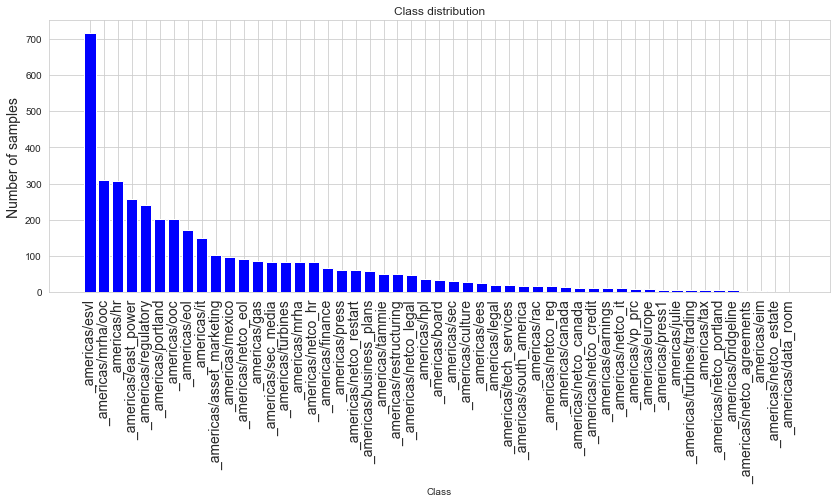

In [153]:
count_map = Counter(kitchen_l_email['Folder'])
num_labels = len(count_map.keys())
count_df = pd.DataFrame({'folders':list(count_map.keys()),'counts':list(count_map.values())})
count_df = count_df.sort_values(by='counts', ascending=False)
idx = np.arange(num_labels)
plt.figure(figsize=(14,5))
plt.bar(count_df.folders, count_df.counts, width=0.8, color='b')
plt.xlabel('Class')
plt.ylabel('Number of samples', fontsize=14)
plt.title('Class distribution')
plt.xticks(
    rotation=90,
    fontsize=14,
)
plt.show()

In [99]:
# Number of words per sample: Median number of words in one sample.
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, (max, median, mean, min) number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.max(num_words), np.mean(num_words), np.median(num_words), np.min(num_words)


In [100]:
num_words_message = get_num_words_per_sample(kitchen_l_email['message'])
num_words_body = get_num_words_per_sample(kitchen_l_email['Body'])
print(num_words_message,num_words_body)

(43987, 605.4610793334991, 215.0, 44) (43945, 519.9318577468291, 129.0, 1)


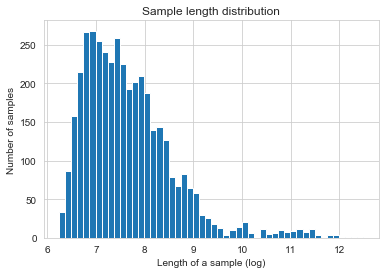

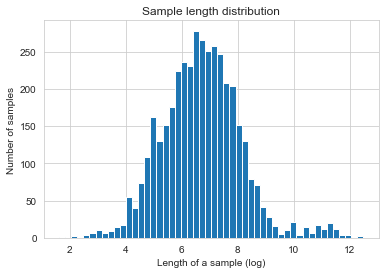

In [101]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([np.log(len(s)) for s in sample_texts], 50)
    plt.xlabel('Length of a sample (log)')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

plot_sample_length_distribution(kitchen_l_email['message'])
#plot_sample_length_distribution(kitchen_l_email['Body'])

In [121]:
# Calculate the number of samples/number of words per sample ratio.
num_samples/num_words_body[2]

31.170542635658915

# Data Cleaning

In [122]:
kitchen_l_email.columns

Index(['file', 'message', 'Date', 'From', 'Subject', 'X-Folder', 'Employee',
       'Folder', 'Email Number', 'Body', 'Related Parties'],
      dtype='object')

In [154]:
kl_email = kitchen_l_email[['Date', 'Subject', 'Folder', 'Body', 'Related Parties']]

In [155]:
kl_email = kl_email.sort_values(by='Date')

In [159]:
#Folder resumes classification
kl_email_esvl = kitchen_l_email[['Subject','Related Parties','Body','Folder']]

In [160]:
kl_email_esvl['Label'] = list(map(int, kl_email_esvl.Folder=='_americas/esvl'))

/Users/ll/anaconda3/envs/transformers/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [163]:
kl_email_esvl.Label.value_counts()

0    3306
1     715
Name: Label, dtype: int64

In [165]:
X = kl_email_esvl['Body'] # the features we want to analyze
ylabels = kl_email_esvl['Label'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=0, shuffle=False)

In [247]:
print(X_train.shape,X_test.shape)

(2814,) (1207,)


In [256]:

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            #'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
            'stop_words': 'english',
            'max_df':1.0,
            'min_df': 1

        
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)
    #print(vectorizer.get_feature_names()[0:50])
    #print("stop_words_:",vectorizer.stop_words_)
    #print("vocabulary_:", vectorizer.vocabulary_)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [257]:
t1, t2=ngram_vectorize(list(X_train), list(y_train), list(X_test))

In [244]:
print(t1.shape,t2.shape)

(2814, 240041) (1207, 240041)


In [250]:
print(t1.shape,t2.shape)

(2814, 20000) (1207, 20000)


In [258]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [276]:
import tensorflow
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [277]:
def train_ngram_model(data,num_classes,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2
                      
                     ):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = explore_data.get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = vectorize_data.ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = build_model.mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('kl_email_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [ ]:
data = ((t1,y_train), (t2, y_test))
train_ngram_model(data,2)

In [13]:
# Implementing lemmatization
lem = nlp("run runs running runner")
# finding lemma for each word
for word in lem:
    print(word.text,word.lemma_)

run run
runs run
running run
runner runner


In [258]:
# POS tagging

# importing the model en_core_web_sm of English for vocabluary, syntax & entities
import en_core_web_sm

# load en_core_web_sm of English for vocabluary, syntax & entities
nlp = en_core_web_sm.load()

#  "nlp" Objectis used to create documents with linguistic annotations.
docs = nlp(kv_input.iloc[0]['Body'])

for word in docs:
    print(word.text,word.pos_)

vincent ADJ
, PUNCT
  SPACE
We PRON
are VERB
capturing VERB
vega ADJ
everyday ADV
now ADV
, PUNCT
but CCONJ
limited ADJ
validation NOUN
on ADP
the DET
vega NOUN
is VERB
  SPACE
down PART
! PUNCT
  SPACE
I PRON
think VERB
we PRON
need VERB
to PART
coordinate VERB
with ADP
Debbie PROPN
and CCONJ
Rudi PROPN
on ADP
this DET
one NOUN
. PUNCT
  SPACE
Regards PROPN
  SPACE
Jonathan PROPN
     SPACE
Vincent PROPN
Tang PROPN
11/29/99 NUM
11:41 NUM
AM NOUN
To ADP
: PUNCT
Jonathan PROPN
Le PROPN
/ SYM
HOU PROPN
/ SYM
ECT@ECT PROPN
cc NOUN
: PUNCT
   SPACE
Subject PROPN
: PUNCT
vega NOUN
position NOUN
  SPACE
Jonathan PROPN
, PUNCT
  SPACE
The DET
vega NOUN
Var PROPN
will VERB
be VERB
implemented VERB
soon ADV
, PUNCT
I PRON
am VERB
wondering VERB
whether ADP
we PRON
capture VERB
all DET
  SPACE
the DET
vega ADJ
position NOUN
in ADP
the DET
database NOUN
now ADV
? PUNCT
Thanks NOUN
, PUNCT
  SPACE
Vincent PROPN


In [16]:
from spacy import displacy

nytimes= nlp(u"""New York City on Tuesday declared a public health emergency and ordered mandatory measles vaccinations amid an outbreak, becoming the latest national flash point over refusals to inoculate against dangerous diseases.

At least 285 people have contracted measles in the city since September, mostly in Brooklyn’s Williamsburg neighborhood. The order covers four Zip codes there, Mayor Bill de Blasio (D) said Tuesday.

The mandate orders all unvaccinated people in the area, including a concentration of Orthodox Jews, to receive inoculations, including for children as young as 6 months old. Anyone who resists could be fined up to $1,000.""")

entities=[(i, i.label_, i.label) for i in nytimes.ents]
entities

[(New York City, 'GPE', 382),
 (Tuesday, 'DATE', 388),
 (At least 285, 'CARDINAL', 394),
 (September, 'DATE', 388),
 (Brooklyn, 'GPE', 382),
 (Williamsburg, 'GPE', 382),
 (four, 'CARDINAL', 394),
 (Zip, 'PERSON', 378),
 (Bill de Blasio, 'PERSON', 378),
 (Tuesday, 'DATE', 388),
 (Orthodox, 'NORP', 379),
 (Jews, 'NORP', 379),
 (6 months old, 'DATE', 388),
 (1,000, 'MONEY', 391)]

In [17]:
displacy.render(nytimes, style = "ent",jupyter = True)

# Text Classification

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [217]:
kv_input.label.value_counts()

0    3934
1     547
Name: label, dtype: int64

In [23]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [236]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    #text = re.sub(r'[-.~/+=(){}]*','', text)
    return text.strip().lower()


In [142]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [143]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [237]:
from sklearn.model_selection import train_test_split

X = kv_input['Body'] # the features we want to analyze
ylabels = kv_input['Label'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=0, shuffle=False)


In [219]:
X_train.shape,X_test.shape

((3136,), (1345,))

In [238]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=200,random_state=0)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x11e0f0ba8>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 toke...'(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x119ddba60>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
          

In [239]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression F1:",metrics.f1_score(y_test, predicted))

Logistic Regression Accuracy: 0.9256505576208178
Logistic Regression Precision: 0.8134328358208955
Logistic Regression Recall: 0.592391304347826


In [48]:
from sklearn.metrics import confusion_matrix

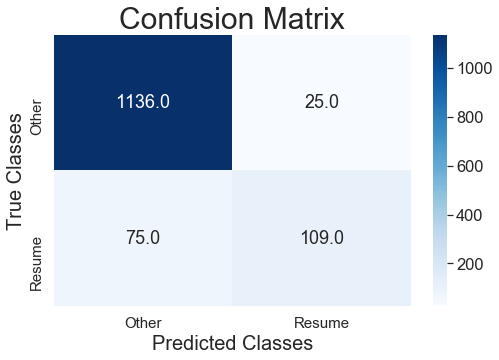

In [240]:
labels=["Other", "Resume"]
confusion = confusion_matrix(y_test,predicted)
sns.set(font_scale=1.5)    
plt.figure(figsize=(8,5))
ax = sns.heatmap(confusion, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix", fontsize = 30)
plt.xlabel('Predicted Classes', fontsize = 20)
plt.ylabel('True Classes', fontsize = 20)
plt.tick_params(labelsize = 15)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [60]:
bow_vector.fit(X_train,y_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x119ddba60>,
                vocabulary=None)

In [78]:
tn=200
history =bow_vector.fit_transform(X_train.iloc[0:tn],y_train.iloc[0:tn])

In [71]:
X_train.iloc[0]

'vincent,  We are capturing vega everyday now, but limited validation on the vega is  down!  I think we need to coordinate with Debbie and Rudi on this one.  Regards  Jonathan     Vincent Tang 11/29/99 11:41 AM To: Jonathan Le/HOU/ECT@ECT cc:   Subject: vega position  Jonathan,  The vega Var will be implemented soon, I am wondering whether we capture all  the vega position in the database now? Thanks,  Vincent'

In [72]:
X_train.iloc[1]

'Hello all:  In case any of you feel energetic, "the boxes are here".  They are located at 2963B (Michael Sergeev\'s old desk).  Feel free to take as many as you will need.  Be sure to label everything with your new office location. If your file cabinets lock, you can just label them and lock them.  Again, listed below is your new office location:  Stinson Gibner  EB 1936 Joseph Hrgovcic EB 1947 Paulo Issler  EB 1935 Vince Kaminski  EB 1933 Krishna Krishnarao EB 1938 Martin Lin  EB 1930E Grant Masson  EB 1941 Kevin Moore  EB 1944 Maureen Raymond EB 1928 Mike Roberts  EB 1945 Vasant Shanbhogue EB 1949 Vincent Tang  EB 1934 Ravi Thuraisingham EB 1932 Zimin Lu  EB 1942  If you have any questions, or need any assistance, please contact me, Kevin, or Sam.  Thanks and have a great day!  Shirley 3-5290'

In [73]:
X_train.iloc[2]

'Thank you.'

In [148]:
print(bow_vector.get_feature_names())

["''", "'s", '0', '00', '000', '0000', '000000000003619', '000000000003991', '000000000003997', '000000000005168', '000000000005409', '000000000005411', '000000000005412', '000000000005413', '000000000005820', '000000000006238', '000000000006452', '000000000007494', '000000000007498', '000000000007876', '000000000010552', '000000000011185', '000000000012677', '000000000012734', '000000000012735', '000000000012736', '000000000012738', '000000000012741', '000000000012987', '000000000013085', '000000000013287', '000001c05ee3$91887440$fd8301ca@euentergycom', '000010220', '0000102317', '0000102374', '0000102789', '0000104281', '0000104282', '0000104486', '0000104631', '0000104730', '0000104776', '0000104778', '0000107043', '0001', '000166', '000f01bfcc01$2c1e9aa0$311da0d4@m0c2f7', '001', '0011', '0011100038', '001201c03f99$e993d620$ddcbd7cc@default', '0017', '001901c02e5e$dcf633a0$ec7d2080@ieorberkeleyedu', '002', '0023', '002813', '002c01c01be9$be6fc5e0$08c9d7cc@default', '003', '00343938a

In [75]:
X_train.iloc[3],y_train.iloc[3]

('Vince,  Dec. 29 at 9:00 will be fine.  I have talked to Shirley and have directions.  Thanks, Bob  Vince J Kaminski wrote:  > Bob, > > Can you come to our office on Dec 29 at 9:00 a.m.? > > Please, call Shirley Crenshaw (3-5290) or Stinson Gibner (3-4748) > from the reception to be admitted to the building. > > Vince Kaminski',
 1)

In [111]:
test=kaminski_v_email.loc[209555].Body

In [112]:
test=re.sub(r'-*','', test)

In [113]:
test

'FYI    Forwarded by Shirley Crenshaw/HOU/ECT on 03/10/2000  07:10 AM    Shirley Crenshaw 03/10/2000 07:06 AM To: Lacima <Lacima@compuserve.com> @ ENRON cc:   Subject: Re: Energy Derivative Courses    Hi Julie:  Here is the information you requested:  Name:  Vince Kaminski Title:  Managing Director and Head of Research Company: Enron Corp. Address: 1400 Smith Street  EB1962   Houston, TX 77002 Telephone: (713) 8533848 (Vince)  (713) 8535290 (Shirley) Fax:  (713) 6462503  If you need anything else, please let me know.  Thanks and have a great day!  Shirley Administrative Coordinator Enron Corp. Research        Lacima <Lacima@compuserve.com>@compuserve.com> on 03/09/2000 04:09:20 PM To: enron <Shirley.Crenshaw@enron.com> cc:   Subject: Energy Derivative Courses   Dear Shriley,  Thank you for registering Vince Kaminski for the energy courses to be held in  Houston, 2931 March.  To complete the registration, could you please provide and confirm the  following details:  Name:  Vince Kaminsk

# Multi-Fields

In [249]:
kv_input_mf = pd.DataFrame({'Subject':kaminski_v_email_sort['Subject'], 'Related Party': kaminski_v_email_sort['Related Party'], 'Body':kaminski_v_email_sort['Body'], 'Label':list(map(int, kaminski_v_email_sort.Folder=='resumes'))})

In [250]:
kv_input_mf

,Subject,Related Party,Body,Label
227253,Re: vega position,"[debbie.brackett@enron.com, ganapathy.ramesh@e...","vincent, We are capturing vega everyday now, ...",0
210435,Research Group Move to the 19th Floor,"[grant.masson@enron.com, joseph.hrgovcic@enron...","Hello all: In case any of you feel energetic,...",0
209880,Re: Rankings,"[brad.mcsherry@enron.com, vince.kaminski@enron...",Thank you.,0
221267,Re: Visit to Enron,"[rrlee@bizserve.com, vince.kaminski@enron.com]","Vince, Dec. 29 at 9:00 will be fine. I have ...",1
210434,Christmas Baskets,"[kevin.moore@enron.com, mike.roberts@enron.com...",The Christmas Baskets have been ordered. We...,0
...,...,...,...,...
227339,FW: Memo: RE: your work phone number,"[iris.mack@enron.com, j.kaminski@enron.com, jo...","Hi, I am forwarding an email from a former B...",0
209944,Resignation effective June 5,"[j.kaminski@enron.com, stinson.gibner@enron.com]","Vince, I am planning to make my resignation f...",0
211125,California Update 5/22/01,"[britt.whitman@enron.com, chris.gaskill@enron....",PLEASE TREAT AS CONFIDENTIAL A source had a m...,0
211669,FW: Report to Professor Duffie,"[iris.mack@enron.com, j.kaminski@enron.com]",You warned me not to say disparaging remarks a...,0


In [251]:
temp = []
for i in range(len(kv_input_mf)):
    temp.append(kv_input_mf.Subject.iloc[i]+' '+' '.join(kv_input_mf['Related Party'].iloc[i])+' '+kv_input_mf.Body.iloc[i])
kv_input_mf['Multi-Fields'] = temp
X = kv_input_mf['Multi-Fields'] # the features we want to analyze
ylabels = kv_input_mf['Label'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=0, shuffle=False)
X_train.shape,X_test.shape

((3136,), (1345,))

In [244]:
X_train

227253    Re: vega position debbie.brackett@enron.com ga...
210435    Research Group Move to the 19th Floor grant.ma...
209880    Re: Rankings brad.mcsherry@enron.com vince.kam...
221267    Re: Visit to Enron rrlee@bizserve.com vince.ka...
210434    Christmas Baskets kevin.moore@enron.com mike.r...
                                ...                        
221375    Jones Graduate School Course Descriptions List...
226767    California Power Update 1/17/01 pt.III gary.hi...
226807    Re: Schedule for trip christie.patrick@enron.c...
220872    Enron Cover Letter & Resume for Dave Gershenso...
220871    Re: Enron Cover Letter & Resume for Dave Gersh...
Name: All, Length: 3136, dtype: object

In [252]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=200,random_state=0)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x11ea9f630>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 toke...'(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x119ddba60>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
          

In [253]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression F1:",metrics.f1_score(y_test, predicted))

Logistic Regression Accuracy: 0.9256505576208178
Logistic Regression Precision: 0.8
Logistic Regression Recall: 0.6086956521739131
Logistic Regression F1: 0.6913580246913581


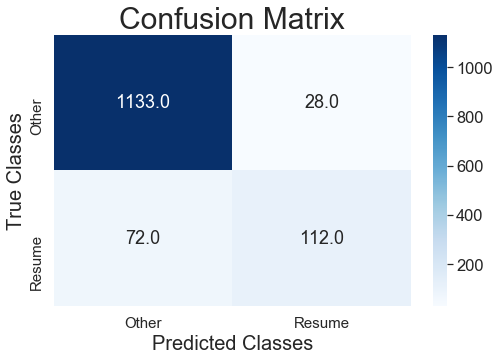

In [247]:
labels=["Other", "Resume"]
confusion = confusion_matrix(y_test,predicted)
sns.set(font_scale=1.5)    
plt.figure(figsize=(8,5))
ax = sns.heatmap(confusion, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix", fontsize = 30)
plt.xlabel('Predicted Classes', fontsize = 20)
plt.ylabel('True Classes', fontsize = 20)
plt.tick_params(labelsize = 15)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [182]:
tn=5
history =bow_vector.fit_transform(X_train.iloc[0:tn],y_train.iloc[0:tn])
print(history)

  (0, 3)	1
  (1, 2)	1
  (1, 1)	1
  (2, 0)	1


  (0, 9)	1
  (0, 6)	1
  (1, 8)	1
  (1, 5)	1
  (1, 0)	1
  (1, 4)	1
  (2, 7)	1
  (3, 10)	1
  (3, 3)	1
  (4, 2)	1
  (4, 1)	1


In [178]:
print(bow_vector.get_feature_names())

['19th', 'basket', 'christmas', 'enron', 'floor', 'group', 'position', 'ranking', 'research', 'vega', 'visit']


# Using All Message

In [286]:
kv_input_all = pd.DataFrame({'Message':kaminski_v_email_sort['message'],'Label':list(map(int, kaminski_v_email_sort.Folder=='resumes'))})
X = kv_input_all['Message'] # the features we want to analyze
ylabels = kv_input_all['Label'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=0, shuffle=False)

In [287]:
X_train.shape,X_test.shape

((3136,), (1345,))

In [275]:
# model generation
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x11ea9f630>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 toke...'(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x119ddba60>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
          

In [265]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression F1:",metrics.f1_score(y_test, predicted))

Logistic Regression Accuracy: 0.9561338289962825
Logistic Regression Precision: 0.9562043795620438
Logistic Regression Recall: 0.7119565217391305
Logistic Regression F1: 0.8161993769470406


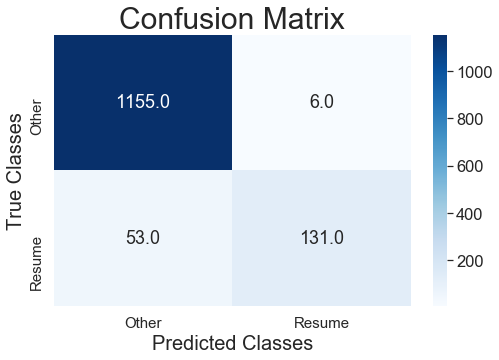

In [266]:
labels=["Other", "Resume"]
confusion = confusion_matrix(y_test,predicted)
sns.set(font_scale=1.5)    
plt.figure(figsize=(8,5))
ax = sns.heatmap(confusion, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix", fontsize = 30)
plt.xlabel('Predicted Classes', fontsize = 20)
plt.ylabel('True Classes', fontsize = 20)
plt.tick_params(labelsize = 15)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# SMOTE

In [303]:
#Let us try some sampling technique to remove class imbalance
from imblearn.over_sampling import SMOTE
#Over-sampling: SMOTE
#SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, 
#based on those that already exist. It works randomly picking a point from the minority class and computing 
#the k-nearest neighbors for this point.The synthetic points are added between the chosen point and its neighbors.
#We'll use ratio='minority' to resample the minority class.
smote = SMOTE('minority', random_state=0)
#X_train = pd.DataFrame(X_train, columns =['Message']) # the features we want to analyze
pipe2 = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector)])
X_vec=pipe2.fit_transform(X_train,y_train)
print(X_vec.shape)
#print(bow_vector.get_feature_names())
print(X_vec.toarray())

(3136, 35364)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [304]:
X_sm, y_sm = smote.fit_sample(X_vec, y_train)
print(X_sm.shape, y_sm.shape)
y_sm.sum()

(5546, 35364) (5546,)


2773

In [305]:
classifier.fit(X_sm,y_sm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [307]:
# Predicting with a test dataset
X_test_vec=pipe2.transform(X_test)
print(X_test_vec.shape)
predicted = classifier.predict(X_test_vec)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression F1:",metrics.f1_score(y_test, predicted))

(1345, 35364)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Logistic Regression Accuracy: 0.9568773234200744
Logistic Regression Precision: 0.9772727272727273
Logistic Regression Recall: 0.7010869565217391
Logistic Regression F1: 0.8164556962025317


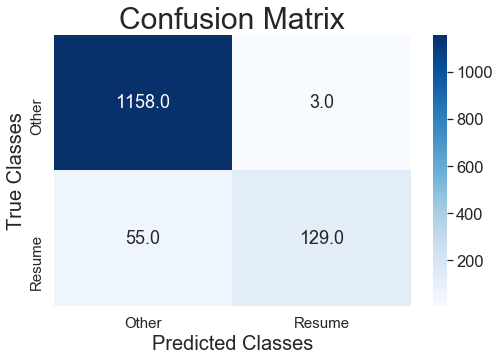

In [308]:
labels=["Other", "Resume"]
confusion = confusion_matrix(y_test,predicted)
sns.set(font_scale=1.5)    
plt.figure(figsize=(8,5))
ax = sns.heatmap(confusion, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix", fontsize = 30)
plt.xlabel('Predicted Classes', fontsize = 20)
plt.ylabel('True Classes', fontsize = 20)
plt.tick_params(labelsize = 15)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

# Multi_Class Classification

In [509]:
kv_multiclass = pd.DataFrame({'Message':kaminski_v_email_sort['message'],'Label':kaminski_v_email_sort['labels']})
X = kv_multiclass['Message'] # the features we want to analyze
ylabels = kv_multiclass['Label'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=0, shuffle=False)

In [312]:
X_train.shape,X_test.shape

((3136,), (1345,))

In [317]:
# model generation
classifier = LogisticRegression(max_iter=500,random_state=0)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])


pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x1a2a3aec50>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 tok...'(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x119ddba60>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
          

In [501]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

In [320]:
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted, average='macro'))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted, average='macro'))
print("Logistic Regression F1:",metrics.f1_score(y_test, predicted, average='macro'))

Logistic Regression Accuracy: 0.704089219330855
Logistic Regression Precision: 0.7643701159023384
Logistic Regression Recall: 0.6772912802095724
Logistic Regression F1: 0.6830778748543649


In [321]:
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted, average='weighted'))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted, average='weighted'))
print("Logistic Regression F1:",metrics.f1_score(y_test, predicted, average='weighted'))

Logistic Regression Accuracy: 0.704089219330855
Logistic Regression Precision: 0.7495787555251058
Logistic Regression Recall: 0.704089219330855
Logistic Regression F1: 0.6848004291141233


In [325]:
confusion = confusion_matrix(y_test,predicted)
print(confusion)

[[164   1   1   3   1   2   0   0   0   0   0   0   0   0   0   0   0  12]
 [  4 117   2   3   2   0   2   0   0   0   0   0   1   0   0   0   0   7]
 [  0   2  80   0   0   2   1   0   1   2   0   0   0   0   0   0   0   4]
 [  2   1   1 115   0   0   0   0   0   0   0   1   0   0   0   0   0   0]
 [  1   4   0   1  55   0   6   0   0   0   0   0   0   0   0   0   0   5]
 [  2   0   0   2   0  57   2   1   0   0   0   0   0   0   0   0   0   8]
 [  0   5   3   0   0   2  49   0   0   3   0   0   1   0   0   0   0  11]
 [  0   3   0   2   0   1   0  40   0   0   0   1   0   0   0   3   0   4]
 [  1   9   2   0   0   0   2   0  13   0   0   0   0   0   0   0   1   2]
 [  0   0   1   0   0   0   0   2   0  35   0   0   0   0   0   0   0  15]
 [ 10   4  11  29   4  18   0   1   0   0  36   0   0   0   0   0   0  34]
 [  0   0   0   0   0   0   0   0   0   0   0  22   0   0   0   0   0   1]
 [  0   1   0   0   0   0   0   0   1   0   0   0  23   0   0   0   0   4]
 [  0   0   0   1   0   0

In [333]:
kaminski_v_email_sort.count().keys()

Index(['file', 'message', 'Date', 'From', 'Subject', 'X-Folder', 'Employee',
       'Folder', 'Email Number', 'Body', 'Related Party', 'labels'],
      dtype='object')

In [499]:
import itertools
def plot_confusion_matrix0(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    #fig, ax = plt.subplots()
    plt.imshow(cm,cmap=cmap)
    plt.title(title, verticalalignment="bottom",fontsize=28)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="pink" if cm[i, j] > thresh else "black"
                )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #bottom, top = ax.set_ylim()
    #ax.set_ylim(bottom + 1, top - 1)

Normalized confusion matrix


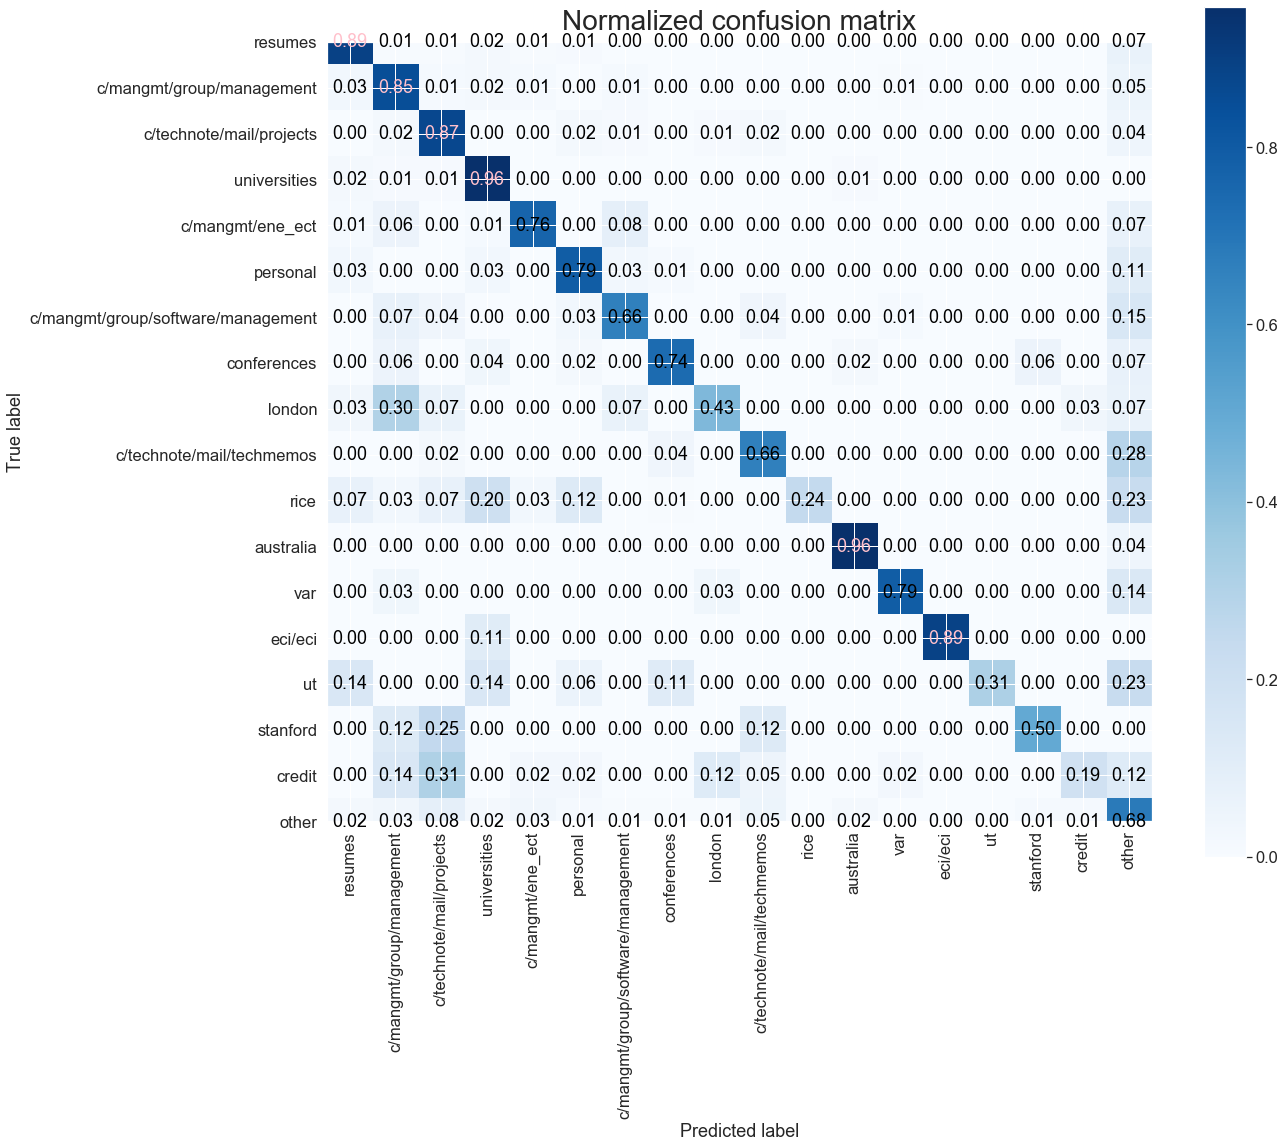

In [500]:
# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(19, 16, forward=True)
#fig.align_labels()

#fig.subplots_adjust(left=0.0, right=0.1, bottom=0.0, top=0.1)
plot_confusion_matrix0(confusion, classes=np.asarray(kv_labels), normalize=True,
                      title='Normalized confusion matrix')


In [505]:
kv_labels_count[kv_labels]

Folder
resumes                               547
c/mangmt/group/management             526
c/technote/mail/projects              379
universities                          367
c/mangmt/ene_ect                      288
personal                              281
c/mangmt/group/software/management    276
conferences                           223
london                                195
c/technote/mail/techmemos             187
rice                                  175
australia                             112
var                                   110
eci/eci                               108
ut                                     76
stanford                               76
credit                                 65
other                                 490
Name: message, dtype: int64

In [57]:
kaminski_v_email_sort.shape

(4481, 12)

In [ ]:
from sklearn.model_selection import cross_val_score

>>> clf = DecisionTreeClassifier(random_state=0)
>>> iris = load_iris()
>>> cross_val_score(clf, iris.data, iris.target, cv=10)

In [510]:
scores = cross_validate(pipe, X, y, cv=3,scoring=('r2', 'f1'), return_train_score=True)
print(scores['f1'])
print(scores['train_r2'])

NameError: name 'cross_validate' is not defined

# Random Forest

In [508]:
from sklearn.tree import DecisionTreeClassifier
kv_multiclass = pd.DataFrame({'Message':kaminski_v_email_sort['message'],'Label':kaminski_v_email_sort['labels']})
X = kv_multiclass['Message'] # the features we want to analyze
ylabels = kv_multiclass['Label'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3, random_state=0, shuffle=False)
X_train.shape,X_test.shape

((3136,), (1345,))

In [317]:
# model generation
classifier_rf = LogisticRegression(max_iter=500,random_state=0)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])


pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x1a2a3aec50>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 tok...'(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x119ddba60>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
          